# Theme 4 Supplement - Coastal Ocean Dynamics and Ecosystems
## Shelf/Slope Exchange
## Plotting Satellite SST Data
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on July 14, 2020._

**Objective**: Demonstrate how to access satellite Sea Surface Temperature data from individual NOAA AVHRR satellite passes from the Mid-Atlantic Regional Association Coastal Ocean Observing System ([MARACOOS](https://maracoos.org/)) and make plots.

The images in this notebook were re-created after the satellite images described in [Frontal Subduction of the Mid‐Atlantic Bight Shelf Water at the Onshore Edge of a Warm‐Core Ring by Zhang and Partida 2018](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2018JC013794).

In [1]:
# Notebook Setup
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data Access

The MARACOOS THREDDs server can be accessed [here](http://tds.maracoos.org/thredds/catalog.html). For this example, we will be using the University of Delaware AVHRR (SST) - archive (yearly), [Masked Single Pass Aggregation for 2014](http://tds.maracoos.org/thredds/ARCHIVE-SST.html?dataset=AVHRR.2014.Masked.Agg). 

Once you've located the dataset, you can access the data using Python via the Data URL found in the OPENDAP link. You will also need to specify:

* the path to a local directory to which you want to save the plots
* the minimum and maximum latitude and longitudes you want to plot
* the date you want to plot (this code will plot all satellite passes during the day specified)

In [2]:
# data url
sat_file = 'http://tds.maracoos.org/thredds/dodsC/AVHRR/2014/Masked/Agg'

# save file directory - change this to a local directory
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite'

# define the coordinate limits to subset and plot
model_lims = dict(minlon=-73, maxlon=-68, minlat=38.2, maxlat=41.8)

# date to plot
plt_date = dt.datetime(2014, 6, 2, 0, 0, 0)

Open the 2014 aggregated satellite data file and subset the dataset for the day you want to plot.

In [3]:
# open the dataset
ds = xr.open_dataset(sat_file, mask_and_scale=False)

# subset based on time
ds = ds.sel(time=slice(plt_date, plt_date + dt.timedelta(days=1)))

# print the dataset to see the dimensions, coordinates, variables, etc
ds

<xarray.Dataset>
Dimensions:  (lat: 3661, lon: 4500, time: 9)
Coordinates:
  * lon      (lon) float64 -100.0 -99.99 -99.98 -99.97 ... -50.02 -50.01 -50.0
  * lat      (lat) float64 20.0 20.01 20.02 20.03 ... 51.98 51.99 51.99 52.0
  * time     (time) datetime64[ns] 2014-06-02T01:51:00 ... 2014-06-02T20:29:00
Data variables:
    mcsst    (time, lat, lon) float32 ...
Attributes:
    url:                       http://www.ceoe.udel.edu, http://marine.rutger...
    groundstation:             RU-COOL L-band receiver at Rutgers University,...
    history:                    
    creator_name:              Matt Oliver
    creator_email:             moliver@udel.edu
    institution:               University of Delaware
    source:                    NOAA AVHRR
    summary:                   Sea surface temperature over the Mid-Atlantic ...
    title:                     AVHRR Sea Surface Temperature for MARACOOS (Mi...
    keywords:                  MARACOOS, AVHRR, SST, UDEL, Satellite SST, Ru

In [4]:
# grab the time, latitude, and longitude variables
tm = ds['time']
lon = ds['lon']
lat = ds['lat']

Print out the time variable - this contains all of the timestamps for the AVHRR satellite passes over the Mid-Atlantic region for the selected date.

In [5]:
# print the time variable
tm

<xarray.DataArray 'time' (time: 9)>
array(['2014-06-02T01:51:00.000000000', '2014-06-02T06:18:00.000000000',
       '2014-06-02T07:59:00.000000000', '2014-06-02T09:05:00.000000000',
       '2014-06-02T10:45:00.000000000', '2014-06-02T15:55:00.000000000',
       '2014-06-02T17:43:00.000000000', '2014-06-02T19:24:00.000000000',
       '2014-06-02T20:29:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-06-02T01:51:00 ... 2014-06-02T20:29:00
Attributes:
    long_name:      Time
    standard_name:  time
    _FillValue:     -2147483647
    _ChunkSizes:    1

This dataset covers the entire Mid-Atlantic region. We want to subset the data to zoom in to the defined Pioneer Array region. In order to do that, we'll create indices where latitude and longitude are within our coordinates defined above, and select the SST data just within those coordinates. The SST variable is called 'mcsst'.

In [6]:
lon_ind = np.logical_and(lon > model_lims['minlon'], lon < model_lims['maxlon'])
lat_ind = np.logical_and(lat > model_lims['minlat'], lat < model_lims['maxlat'])

# grab the SST data within the defined coordinates
sst = np.squeeze(ds['mcsst'][:, lat_ind, lon_ind])
sst

<xarray.DataArray 'mcsst' (time: 9, lat: 423, lon: 450)>
[1713150 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -72.99 -72.98 -72.97 -72.96 ... -68.03 -68.02 -68.0
  * lat      (lat) float64 38.2 38.21 38.22 38.23 ... 41.77 41.78 41.79 41.79
  * time     (time) datetime64[ns] 2014-06-02T01:51:00 ... 2014-06-02T20:29:00
Attributes:
    units:          Celsius
    long_name:      Multichannel Sea Surface Temperature
    _FillValue:     -999.0
    missing_value:  -999.0
    grid_mapping:   crs
    comments:       Projection information found in the crs variable
    standard_name:  sea_surface_temperature
    _ChunkSizes:    [   1  916 1125]

## Set up plot for one timestamp

Here is a function to plot the SST data, add map features to the plot, add the locations of the Pioneer moorings, and save the plot to a directory on your local machine (if the file path is provided).

In [7]:
def plot_sst(plt_ttl, clabel, lon_data, lat_data, data, array_loc, save_figname=None):
    """
    Create a pcolor surface map of SST
    plt_ttl: title for the plot
    clabel: label for the color bar
    lon_data: longitude data
    lat_data: latitude data
    data: variable data
    array_loc: data frame containing mooring coordinates
    save_figname: optional, full file path to save directory and save filename
    """
    # set up the map
    fig, ax = plt.subplots(figsize=(8, 9), subplot_kw=dict(projection=ccrs.PlateCarree()))

    plt.subplots_adjust(right=0.88)  # adjust the right margin of the plot
    plt.title(plt_ttl, fontsize=17)  # add the title

    # format the spacing of the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    fig.add_axes(cax)

    # plot the data
    h = ax.pcolor(lon_data, lat_data, data, vmin=12, vmax=26, cmap='jet')

    # add the color bar
    cb = plt.colorbar(h, cax=cax, extend='both')
    cb.set_label(label=clabel, fontsize=14)  # add the label on the colorbar
    cb.ax.tick_params(labelsize=12)  # format the size of the tick labels

    # add the latitude and longitude gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, color='gray', 
                      alpha=0.5, linestyle='dotted')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    # add map features
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    ax.add_feature(land, edgecolor='black', facecolor='gray')

    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(cfeature.BORDERS, zorder=6)
    ax.add_feature(state_lines, zorder=7, edgecolor='black')
    
    # add the mooring locations
    ax.scatter(array_loc.lon, array_loc.lat, s=45, marker='d', color='w', edgecolor='black')

    # save the figure only if a figure path is provided
    if save_figname is not None:
        plt.savefig(save_figname, dpi=200)

Now, we will get the data for SST just at the first timestamp in our subset time array, get the locations of the Pioneer moorings, and pass all of the information needed to the plotting function.

In [8]:
# get the data for SST at the first timestamp in the time array
t = tm[0]  # grab the first timestamp
sst_t0 = sst.sel(time=t.values)

# convert fill values to NaNs
sst_t0.values[sst_t0 == -999] = np.nan

varname = sst_t0.long_name
print(sst_t0)

<xarray.DataArray 'mcsst' (lat: 423, lon: 450)>
array([[19.5 , 19.35, 19.2 , ...,   nan,   nan,   nan],
       [19.35, 19.2 , 19.2 , ...,   nan,   nan,   nan],
       [19.05, 19.05, 19.35, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -72.99 -72.98 -72.97 -72.96 ... -68.03 -68.02 -68.0
  * lat      (lat) float64 38.2 38.21 38.22 38.23 ... 41.77 41.78 41.79 41.79
    time     datetime64[ns] 2014-06-02T01:51:00
Attributes:
    units:          Celsius
    long_name:      Multichannel Sea Surface Temperature
    _FillValue:     -999.0
    missing_value:  -999.0
    grid_mapping:   crs
    comments:       Projection information found in the crs variable
    standard_name:  sea_surface_temperature
    _ChunkSizes:    [   1  916 1125]


Here is a function to return all of the locations of the moorings from an OOI array, using the [Rutgers OOI Data Review Database](https://datareview.marine.rutgers.edu/).

In [9]:
def return_array_subsites_standard_loc(array):
    DBurl= 'https://datareview.marine.rutgers.edu/regions/view/{}.json'.format(array)
    r = requests.get(DBurl)
    url_ct = r.json()['region']['sites']
    loc_df = pd.DataFrame()
    for ii in range(len(url_ct)):
        if url_ct[ii]['reference_designator'] != 'CP05MOAS':
            data = {
                    'lat': url_ct[ii]['latitude'],
                    'lon': url_ct[ii]['longitude'],
                    'max_z': url_ct[ii]['max_depth']
                    }
            new_r = pd.DataFrame(data, columns=['lat', 'lon', 'max_z'], 
                                 index=[url_ct[ii]['reference_designator']])
            loc_df = loc_df.append(new_r)
    return loc_df

In [10]:
array_location = return_array_subsites_standard_loc('CP')
print(array_location)

              lat      lon  max_z
CP01CNPM  40.1392 -70.7795     70
CP01CNSM  40.1334 -70.7785    133
CP01CNSP  40.1341 -70.7701    133
CP02PMCI  40.2267 -70.8782    127
CP02PMCO  40.0963 -70.8789    148
CP02PMUI  40.3649 -70.7700     95
CP02PMUO  39.9394 -70.7708    452
CP03ISPM  40.3647 -70.8882     70
CP03ISSM  40.3619 -70.8783     92
CP03ISSP  40.3672 -70.8818     92
CP04OSPM  39.9365 -70.8802    453
CP04OSSM  39.9371 -70.8870    450


Define information for the plot, like the label names and save file path.

In [11]:
# define labels for plot
# convert timestamp to string
timestr = dt.datetime.strftime(pd.to_datetime(t.values), '%d %b %Y %H:%M')
print('Currently plotting: {}'.format(timestr))

# define plot title and color label title
title = 'AVHRR {} GMT'.format(timestr)
color_label = 'SST ($^\circ$C)'

Currently plotting: 02 Jun 2014 01:51


## Generate plot

Finally, let's pass the information to the function to create a plot (which may take several minutes to create). This time, we won't pass the save file path (the last argument) to the function, so the plot will be displayed below but not saved to your local machine. After we confirm the plotting function works, we can write a loop to make more than one plot and save those plots to your local machine.

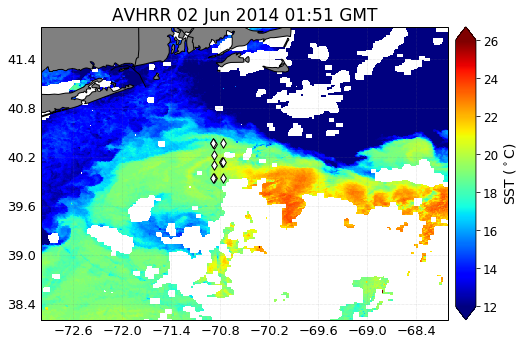

In [12]:
# pass the necessary information to the function to create the plot (without the save file path)
plot_sst(title, color_label, sst_t0.lon.values, sst_t0.lat.values, sst_t0.values, array_location)

Here is a surface image of Sea Surface Temperature from one pass of a satellite at 01:51 GMT on June 2, 2014, with the locations of the Pioneer array moorings indicated by the white diamonds. One thing to note is that these satellite images are often patchy (e.g. clouds can prevent the satellite from recording valid SST data), which is why scientists often create composites of multiple satellite passes to create a more complete picture of what's happening at the Earth's surface. Composites are much more complicated to create so we won't go into that in this tutorial, but you can plot all of the satellite passes in a given day to find some images with decent coverage.

Now that we have verified that the plotting function works, let's generate plots for the entire day and save those images. This will take several minutes.

Currently plotting: 02 Jun 2014 01:51
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite/avhrr_sst_20140602T0151.png
Currently plotting: 02 Jun 2014 06:18
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite/avhrr_sst_20140602T0618.png
Currently plotting: 02 Jun 2014 07:59
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite/avhrr_sst_20140602T0759.png
Currently plotting: 02 Jun 2014 09:05
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite/avhrr_sst_20140602T0905.png
Currently plotting: 02 Jun 2014 10:45
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite/avhrr_sst_20140602T1045.png
Currently plotting: 02 Jun 2014 15:55
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite/avhrr_sst_20140602T1555.png
Currently plotting: 02 Jun 2014 17:43
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme4a_satellite/avhrr_sst_20140602T1743.png
Currently plotting: 02 Jun 2014 19:24
save filep

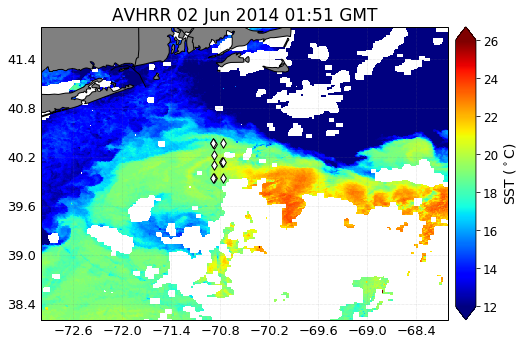

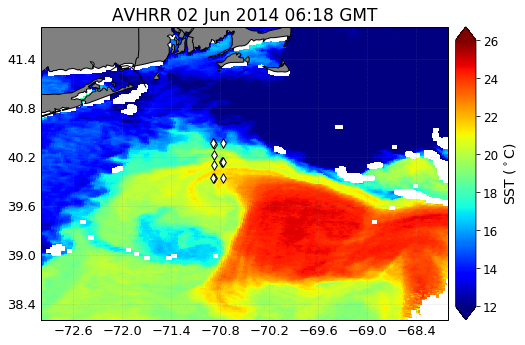

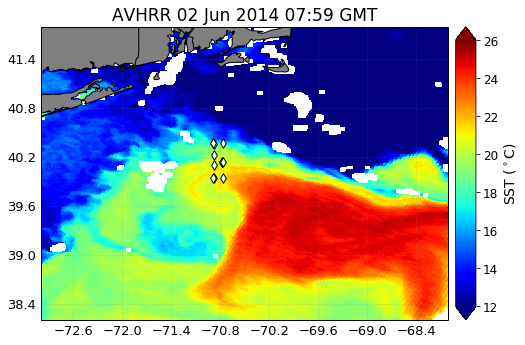

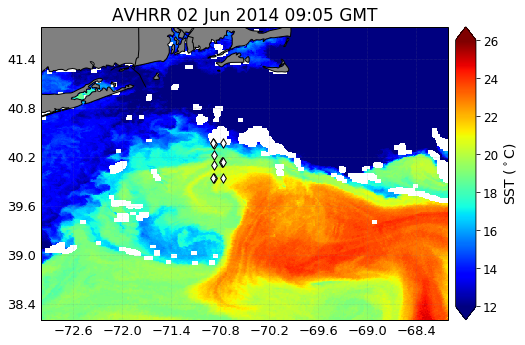

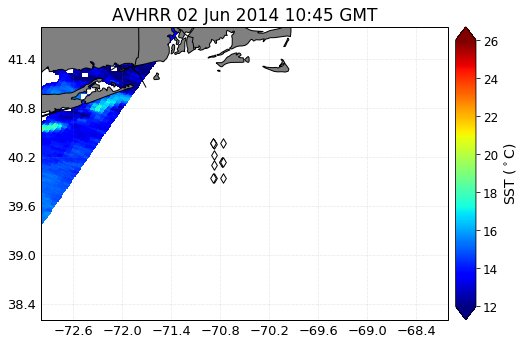

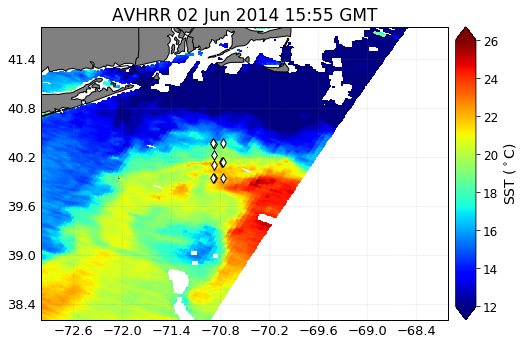

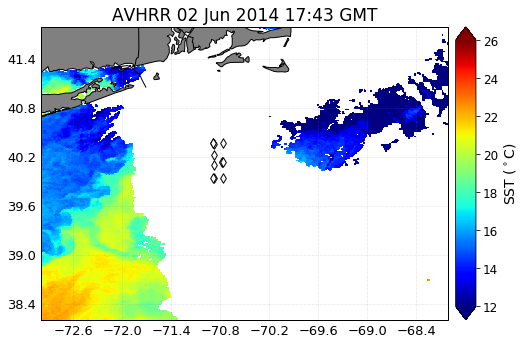

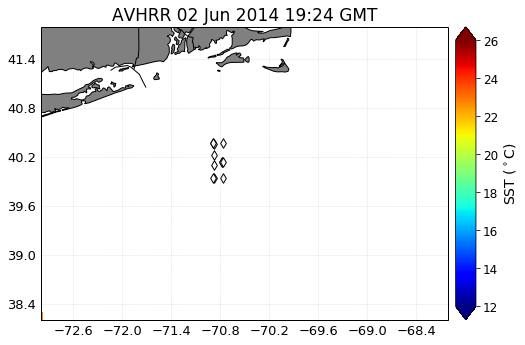

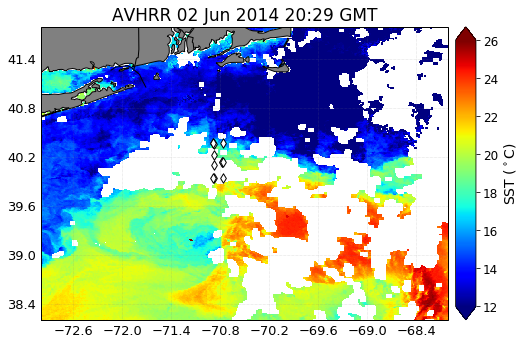

In [13]:
for t in tm:
    # get the SST data at the defined timestamp
    sst_tm = sst.sel(time=t.values)

    # convert fill values to NaNs
    sst_tm.values[sst_tm == -999] = np.nan
    
    lons = sst_tm.lon.values
    lats = sst_tm.lat.values
    
    # define labels for plot
    # convert timestamp to string
    timestr = dt.datetime.strftime(pd.to_datetime(t.values), '%d %b %Y %H:%M')
    print('Currently plotting: {}'.format(timestr))

    # define plot title and color label title
    title = 'AVHRR {} GMT'.format(timestr)
    color_label = 'SST ($^\circ$C)'

    # create a full save file path for the image
    sdate = dt.datetime.strftime(pd.to_datetime(t.values), '%Y%m%dT%H%M')
    figname = 'avhrr_sst_{}.png'.format(sdate)
    sfig = os.path.join(save_dir, figname)
    print('save filepath: {}'.format(sfig))
    
    # pass the necessary information to the function to create the plot, 
    # including the save file path to save plots to local machine
    plot_sst(title, color_label, lons, lats, sst_tm.values, array_location, sfig)

When scrolling through the images created for each satellite pass on this date, you can see that some of the images have good coverage while others contain very little useful information for this region. You can modify the plotting time date at the beginning of the tutorial to create more images for additional days.